# Training, Engineering, and Model Assesment - U-NET DL Model

## Import packages 

In [45]:
# general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# keras/tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K
import keras_tuner as kt
from tensorflow.keras.layers import ZeroPadding1D



# plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Import Data

In [ ]:
# set target (what are we trying to predict)
target = 'pwt_500hpa'
#target = 'temperature_800hpa'
# set lists of coordinates and time ranges (pulled from Prepare_AI_Ready_Data.py)
coords = [[180,240,45,65],[130,250,20,75]]
times = [['1970-01-01','2023-12-31']]  # Ensure the time range is valid

# set PC option - seperate or combined
#PC_option = 'combined'
PC_option = 'seperate'

# select which of the list I want to load
coords_num = 1
times_num = 0

# pull the correct coordinate and time (as set above)
c = coords[coords_num]
t = times[times_num]

# read in PCs
if PC_option == 'combined':
    raw_data = pd.read_csv(f'../data/dimensionality_reduction/principal_components_combined_{c[0]}-{c[1]}_{c[2]}-{c[3]}_{t[0][:4]}-{t[1][:4]}_target.csv')
elif PC_option == 'seperate':
    raw_data = pd.read_csv(f'../data/dimensionality_reduction/principal_components_seperate_{c[0]}-{c[1]}_{c[2]}-{c[3]}_{t[0][:4]}-{t[1][:4]}_target.csv')

# Keep only columns that are target, contain "PC", or contain "month"
#columns_to_keep = [col for col in raw_data.columns if target in col or "PC" in col or "month" in col]
columns_to_keep = [col for col in raw_data.columns if target in col or "PC" in col]
data = raw_data[columns_to_keep]

# normalize all input data to have values between 0 and 1, but keep as a df
scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

In [47]:
# Prep data from ML

# Splitting the data into features X and label y
y = data[target].values  # e.g., binary classification label
X = data.drop(columns=[target]).values
# get names of features
feature_names = data.drop(columns=[target]).columns


# 70% training, 15% validation, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, 
                                                  test_size=0.15, 
                                                  random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, 
                                                  test_size=0.1765,  # 0.1765 of 0.85 ~ 0.15
                                                  random_state=42)

X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_cnn = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
# X_train_cnn = X_train
# X_val_cnn = X_val
# X_test_cnn = X_test

## Hyperparameter Tuning

In [48]:
# Optional helper conv block
def conv_block(x, filters, kernel_size):
    """
    A simple 1D convolution block: Conv -> BN -> ReLU -> Conv -> BN -> ReLU
    """
    x = layers.Conv1D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv1D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    return x


def build_unet_model_with_padding(hp):
    """
    Builds a 1D U-Net for time-series regression, zero-padding from length 30 -> 32.
    """
    # Hyperparameters
    base_filters = hp.Int('base_filters', min_value=8, max_value=64, step=8)
    kernel_size  = hp.Choice('kernel_size', values=[3, 5])
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])

    # Input: shape=(30, 1)
    input_layer = keras.Input(shape=(30, 1))
    
    # ZeroPad from 30 to 32 (2 zeros at the end)
    x = layers.ZeroPadding1D(padding=(0, 2))(input_layer)  # becomes shape=(None, 32, 1)

    # -------------------- Encoder --------------------
    c1 = conv_block(x, base_filters, kernel_size)       # -> (None, 32, base_filters)
    p1 = layers.MaxPooling1D(pool_size=2)(c1)           # -> (None, 16, base_filters)

    c2 = conv_block(p1, base_filters * 2, kernel_size)  # -> (None, 16, base_filters*2)
    p2 = layers.MaxPooling1D(pool_size=2)(c2)           # -> (None, 8,  base_filters*2)

    # -------------------- Bottleneck -----------------
    c3 = conv_block(p2, base_filters * 4, kernel_size)  # -> (None, 8, base_filters*4)

    # -------------------- Decoder --------------------
    # Upsample #1
    u2 = layers.UpSampling1D(size=2)(c3)                # (None, 16, base_filters*4)
    u2 = layers.Concatenate(axis=-1)([u2, c2])          # both have length=16
    c4 = conv_block(u2, base_filters * 2, kernel_size)  # -> (None, 16, base_filters*2)

    # Upsample #2
    u1 = layers.UpSampling1D(size=2)(c4)                # (None, 32, base_filters*2)
    u1 = layers.Concatenate(axis=-1)([u1, c1])          # both have length=32
    c5 = conv_block(u1, base_filters, kernel_size)      # -> (None, 32, base_filters)

    # -------------------- Output Layer (Regression) --
    # GlobalAveragePooling to get a single vector per sample
    gap = layers.GlobalAveragePooling1D()(c5)           # -> (None, base_filters)
    output = layers.Dense(1, activation='linear')(gap)  # single scalar per sample

    model = keras.Model(inputs=input_layer, outputs=output, name="1D_U_Net_ZeroPad")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )
    return model




In [55]:
# Define the Keras Tuner
tuner = kt.RandomSearch(
    build_unet_model_with_padding,
    objective='val_mae',  # Minimizing validation MAE
    max_trials=50,        # How many different parameter sets to try
    executions_per_trial=1,
    directory='../data/my_tuner_dir',
    project_name='unet_regression_padding'
)

# Early Stopping
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_mse',
    patience=3,
    restore_best_weights=True
)

Reloading Tuner from ../data/my_tuner_dir/unet_regression_padding/tuner0.json


In [50]:
t1 = time.perf_counter()
tuner.search(
    X_train_cnn, y_train,
    epochs=20,
    validation_data=(X_val_cnn, y_val),
    callbacks=[early_stop]
)
t2 = time.perf_counter()
hyper_search_time = t2 - t1

Trial 46 Complete [00h 00m 04s]
val_mae: 0.6851370930671692

Best val_mae So Far: 0.6120073795318604
Total elapsed time: 00h 04m 45s


In [56]:
# Retrieve the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# combine train + val data
X_train_val = np.concatenate((X_train_cnn, X_val_cnn), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)

# Perform k-fold cross-validation
num_folds = 10  # Number of folds
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Store the history and MSE for each fold
val_scores = []  # Store validation scores for each fold
histories = []  # Store training history for each fold
best_epochs = []

# Store MSE and  for each fold
fold_mse = []

t1 = time.perf_counter()
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_val)):
    print(f"Training fold {fold + 1}/{num_folds}...")

    # Split data for this fold
    X_train_fold, X_val_fold = X_train_val[train_idx], X_train_val[val_idx]
    y_train_fold, y_val_fold = y_train_val[train_idx], y_train_val[val_idx]

    # Reinitialize model (since Keras models retain state)
    model = keras.models.clone_model(best_model)
    model.compile(optimizer="adam", loss="mse", metrics=["mse"])

    # Train the model with early stopping
    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=20,  # Adjust based on your needs
        batch_size=32,  # Adjust as needed
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stop],
        verbose=0
    )
    
    # Store history for plotting
    histories.append(history.history)
    
    # Store the best epoch (length of training before early stopping)
    best_epochs.append(len(history.history['mse']))

    # Evaluate on validation set
    val_loss, val_mse = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    val_scores.append(val_mse)
    print(f"Fold {fold + 1} Validation MSE: {val_mse:.4f}")
t2 = time.perf_counter()
cv_time = t2 - t1


# Average performance across folds
avg_val_mse = np.mean(val_scores)
avg_best_epoch = int(np.mean(best_epochs))  # Compute average best epoch from k-fold training
print(f"Average Validation MSE: {avg_val_mse:.4f}")
print(f"Using {avg_best_epoch} epochs for final training.")


Training fold 1/10...
Fold 1 Validation MSE: 0.9828
Training fold 2/10...
Fold 2 Validation MSE: 0.8102
Training fold 3/10...
Fold 3 Validation MSE: 0.8836
Training fold 4/10...
Fold 4 Validation MSE: 0.7997
Training fold 5/10...
Fold 5 Validation MSE: 0.5973
Training fold 6/10...
Fold 6 Validation MSE: 0.7599
Training fold 7/10...
Fold 7 Validation MSE: 1.2166
Training fold 8/10...
Fold 8 Validation MSE: 0.6954
Training fold 9/10...
Fold 9 Validation MSE: 1.1868
Training fold 10/10...
Fold 10 Validation MSE: 0.9824
Average Validation MSE: 0.8915
Using 9 epochs for final training.


In [57]:
print("Best Hyperparameters:")
print(best_hps.values)
best_model.summary()

Best Hyperparameters:
{'base_filters': 40, 'kernel_size': 5, 'learning_rate': 0.0005}
Model: "1D_U_Net_ZeroPad"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 30, 1)]      0           []                               
                                                                                                  
 zero_padding1d_2 (ZeroPadding1  (None, 32, 1)       0           ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1d_20 (Conv1D)             (None, 32, 40)       240         ['zero_padding1d_2[0][0]']       
                                                                                                

# Plot Training and Validation MSE Across Folds

This helps us understand how the model reaches it's fit. Here we see evidence of strong overfitting to training data, with failure to produce any predictive power in MSE.

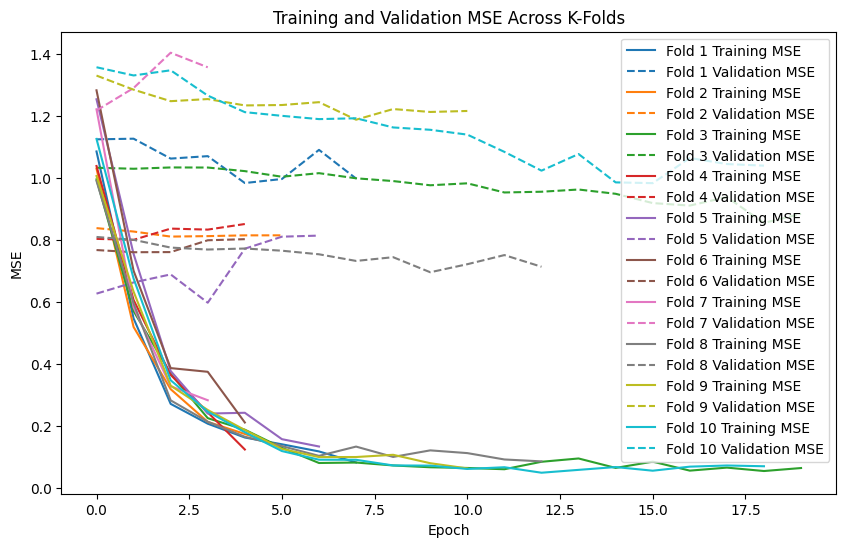

In [58]:
plt.figure(figsize=(10, 6))
colors = plt.cm.tab10.colors  # Use a colormap for consistent colors

for i, history in enumerate(histories):
    plt.plot(history['mse'], label=f'Fold {i+1} Training MSE', color=colors[i % len(colors)])
    plt.plot(history['val_mse'], linestyle='--', label=f'Fold {i+1} Validation MSE', color=colors[i % len(colors)])

plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Training and Validation MSE Across K-Folds")
plt.legend()
plt.show()

## Final model training, with evaluation on test set

Note that here we cannot use early stopping, so instead we train to the average number of folds from the cross validation

In [59]:
from sklearn.metrics import r2_score

# Final Training on Full Train+Val Data 
print("Training final model on full train+val dataset...")

final_model = keras.models.clone_model(best_model)
final_model.compile(optimizer="adam", loss="mse", metrics=["mse"])
t1 = time.perf_counter()
final_model.fit(
    X_train_val, y_train_val,
    epochs=avg_best_epoch,  # Use the averaged best epoch
    batch_size=32,
    verbose=0
)
t2 = time.perf_counter()
print(f"Training time: {t2 - t1:.2f} seconds")

#  Final Evaluation on Test Set 
test_loss, test_mse = final_model.evaluate(X_test, y_test, verbose=1)
print(f"Final Test MSE: {test_mse:.4f}")
# Calculate R^2 score
r2 = r2_score(y_test, final_model.predict(X_test))
print(f"Final Test R^2: {r2:.4f}")

Training final model on full train+val dataset...
Training time: 4.15 seconds
3/3 [==============================] - 0s 6ms/step - loss: 1.1206 - mse: 1.1206
Final Test MSE: 1.1206
3/3 [==============================] - 0s 5ms/step
Final Test R^2: -0.0630


## Save results

Save results to DF for analysis in later notebook

In [60]:

results = pd.DataFrame(columns=['model', '1 Run Time', 'mean_squared_error','mean_r2','Hyperparameter Time','K-Fold Time'])
results = pd.concat([results, pd.DataFrame([{'model': 'U-Net', '1 Run Time': t2-t1, 'mean_squared_error': test_mse, 'mean_r2': r2, 'Hyperparameter Time': hyper_search_time, 'K-Fold Time': cv_time }])], ignore_index=True)
results.to_csv(f'../data/results/unet_results.csv', index=False)

/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_90996/3200192694.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'model': 'U-Net', '1 Run Time': t2-t1, 'mean_squared_error': test_mse, 'mean_r2': r2, 'Hyperparameter Time': hyper_search_time, 'K-Fold Time': cv_time }])], ignore_index=True)
